In [1]:
%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
#import scrublet as scr
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
import harmonypy as hm
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


-----
anndata     0.7.4
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 7.2.0
anndata             0.7.4
annoy               NA
backcall            0.1.0
bbknn               NA
cffi                1.13.2
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.1
fbpca               NA
geosketch           NA
get_version         2.1
h5py                2.10.0
harmonypy           NA
igraph              0.8.0
importlib_metadata  1.5.0
ipykernel           5.1.4
ipython_genutils    0.2.0
ipywidgets          7.5.1
jedi                0.16.0
joblib              0.14.1
kiwisolver          1.1.0
legacy_api_wrap     1.2
leidenalg           0.7.0
llvmlite            0.31.0
louvain             0.6.1
matplotlib          3.1.3
mpl_toolkits        NA
natsort             7.0.1
numba               0.48.0
numexpr             2.7.1
numpy               1.18.1
packaging           20.1
pandas              1.0.1
parso           

In [2]:
#Introduce variables

#name of first object (arbitrary)
data1 = "_Training"
Object1 = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/mouse_gastrulation_human_YS_combination/combined_ys_fliv_mouse_111021.h5ad"

#provide categorical containing batch information
batch = 'fetal.ids'

#Procide PC intervals to study
inte = [1,2,3,4,5,6,7,8,9,10] #thta value

#provide cateorical to join between datasets, this shoould be annotations for cells (obs col)
cat1 = 'cell.labels'

#Use BBKNN or Harmony? 
correction = "Harmony"

#provide an output path and a folder name to be created
output = "./logit_regression_out_harmony_theta_var_v3/"

## Start of processing module

In [3]:
# Load dataset 1
adata_orig = sc.read(Object1)

# LR function

In [4]:
def LR_compare(adata, train_x ,train_label,subset_predict, subset_train,penalty='l2',sparcity=0.2,col_name='predicted'):
    #Define LR parameters
    penalty='l2'
    sparcity=0.2
    lr = LogisticRegression(penalty=penalty, C=sparcity)

    if train_x == 'X':
        train_label = adata.obs[common_cat].values
        train_label = train_label[subset_train]
        train_x = adata.X
        predict_x = train_x
        train_x = train_x[subset_train, :]
        predict_x = train_x
        predict_x = predict_x[subset_predict]


    elif train_x in adata.obsm.keys():
        #Define training parameters
        train_label = adata.obs[common_cat].values
        train_label = train_label[subset_train]
        train_x = adata.obsm[train_x]
        predict_x = train_x
        train_x = train_x[subset_train, :]

        #Define Prediction parameters
        predict_x = predict_x[subset_predict]
        predict_x = pd.DataFrame(predict_x)
        predict_x.index = adata.obs[subset_predict].index

        
    #Train predictive model
    model = lr.fit(train_x, train_label)
    lr.fit(train_x, train_label)
    predict = lr.predict_proba(predict_x)

    #Create prediction table and map to adata.obs
    predict = lr.predict(predict_x)
    predict = pd.DataFrame(predict)
    predict.index = adata.obs[subset_predict].index
    adata.obs[col_name] = adata.obs.index
    adata.obs[col_name] = adata.obs[col_name].map(predict[0])

# Start of predictive and output loop

In [5]:
os.chdir('/home/jovyan/data/projects/f_bm/rebuttal_figs_020221/harmony_param_logit/')
print(os.getcwd())

/home/jovyan/data/projects/f_bm/rebuttal_figs_020221/harmony_param_logit


# Dev Notes

Loop to compute umap coords for each harmony loop, the umap coords can be fed into kbet for testing

## To add:
- Rand and MI to show that logit regression annotation outcome does not change with change in Harmony theta

# Work-in-progress

Trying to set attribute `.obs` of view, copying.


Path already exists!
/home/jovyan/data/projects/f_bm/rebuttal_figs_020221/harmony_param_logit/logit_regression_out_harmony_theta_var_v3


Trying to set attribute `.obs` of view, copying.


data_concatenated!
normalizing by total count per cell
    finished (0:00:13): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:11)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:30)
computing neighbors
    using 'X_pca' with n_pcs = 50


/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../my-conda-envs/base_100920/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../..

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:24)
Commencing harmony


2021-02-04 18:55:11,540 - harmonypy - INFO - Iteration 1 of 10
2021-02-04 18:55:38,402 - harmonypy - INFO - Iteration 2 of 10
2021-02-04 18:56:04,956 - harmonypy - INFO - Iteration 3 of 10
2021-02-04 18:56:32,208 - harmonypy - INFO - Iteration 4 of 10
2021-02-04 18:56:59,141 - harmonypy - INFO - Converged after 4 iterations


computing neighbors
    using 'X_pca' with n_pcs = 50


/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../my-conda-envs/base_100920/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing UMAP


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:45)


/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

LR_predictions completed for loop with harmony thetha = 1!
LR probs saved for loop 1!


... storing 'corr_concat' as categorical
... storing 'predicted' as categorical
... storing 'clus_prediction' as categorical


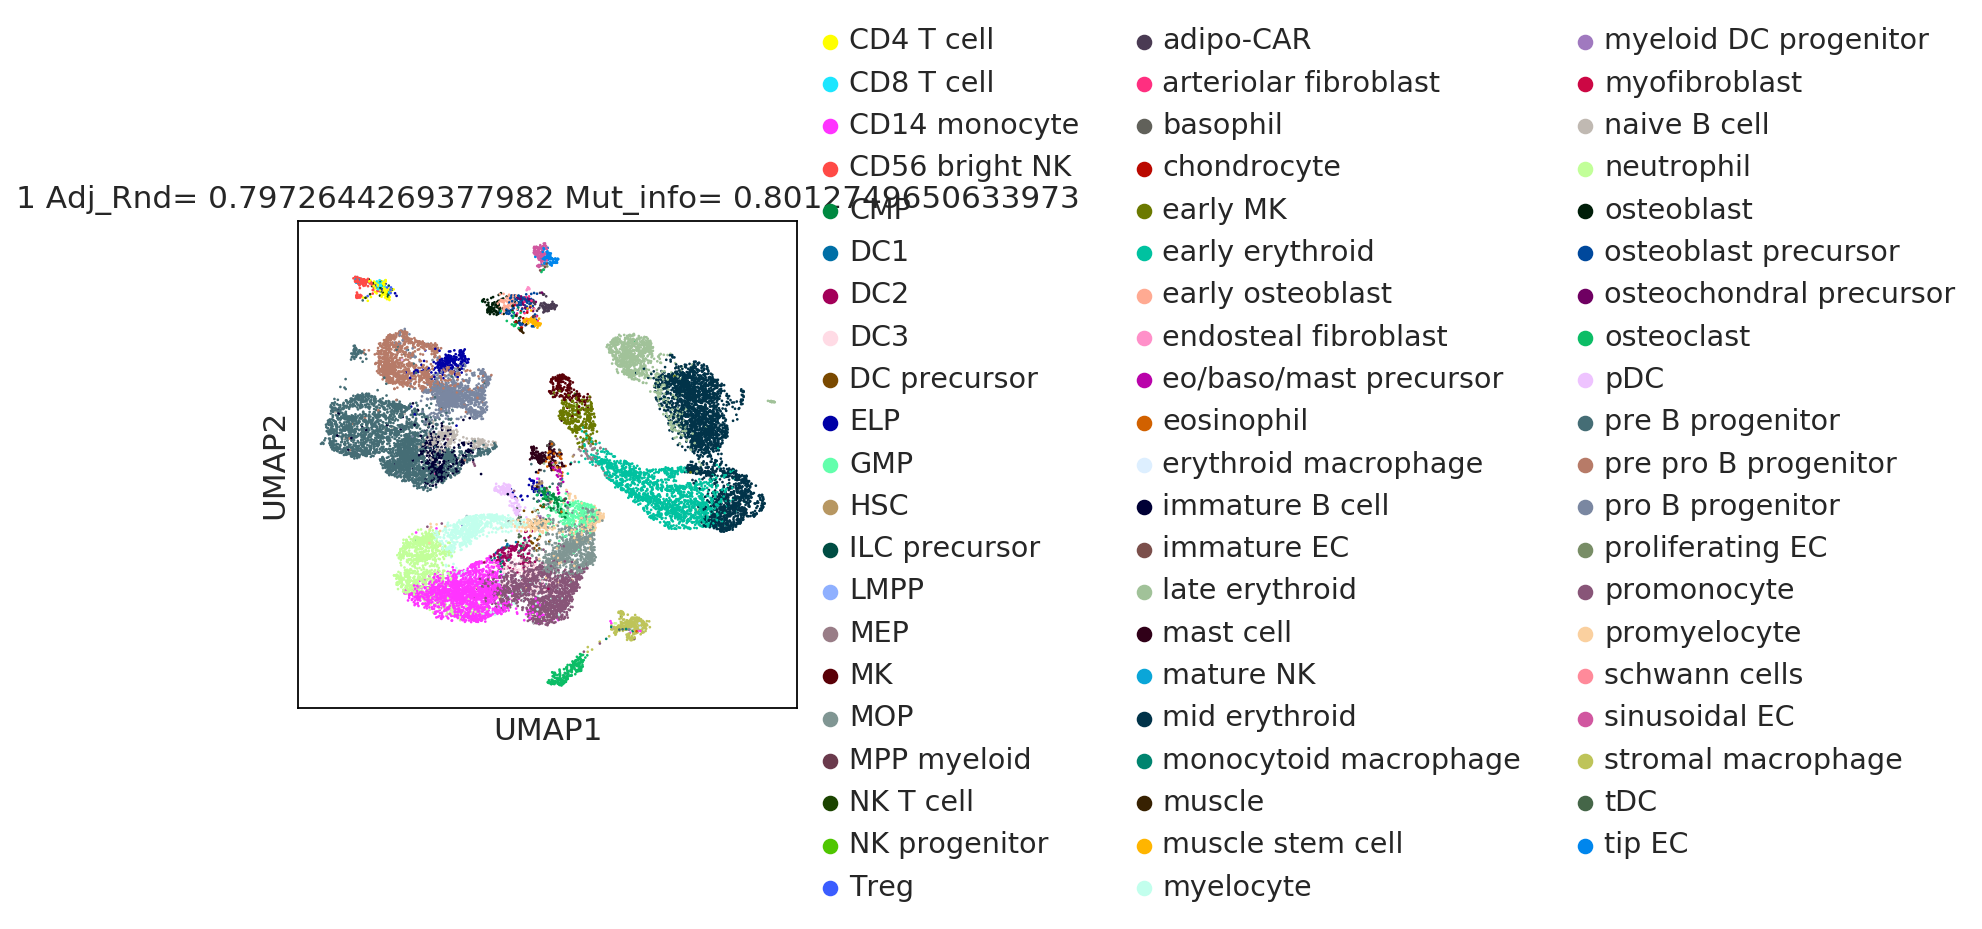

Umap, rand,Mi plotted for loop with harmony theta = 1!
end of loop!
Commencing harmony


2021-02-04 18:58:33,438 - harmonypy - INFO - Iteration 1 of 10
2021-02-04 18:58:59,043 - harmonypy - INFO - Iteration 2 of 10
2021-02-04 18:59:24,118 - harmonypy - INFO - Iteration 3 of 10
2021-02-04 18:59:49,730 - harmonypy - INFO - Iteration 4 of 10
2021-02-04 19:00:15,795 - harmonypy - INFO - Iteration 5 of 10
2021-02-04 19:00:41,430 - harmonypy - INFO - Converged after 5 iterations


computing neighbors
    using 'X_pca' with n_pcs = 50


/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../my-conda-envs/base_100920/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing UMAP


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:45)


/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

LR_predictions completed for loop with harmony thetha = 2!
LR probs saved for loop 2!


... storing 'corr_concat' as categorical
... storing 'predicted' as categorical
... storing 'clus_prediction' as categorical


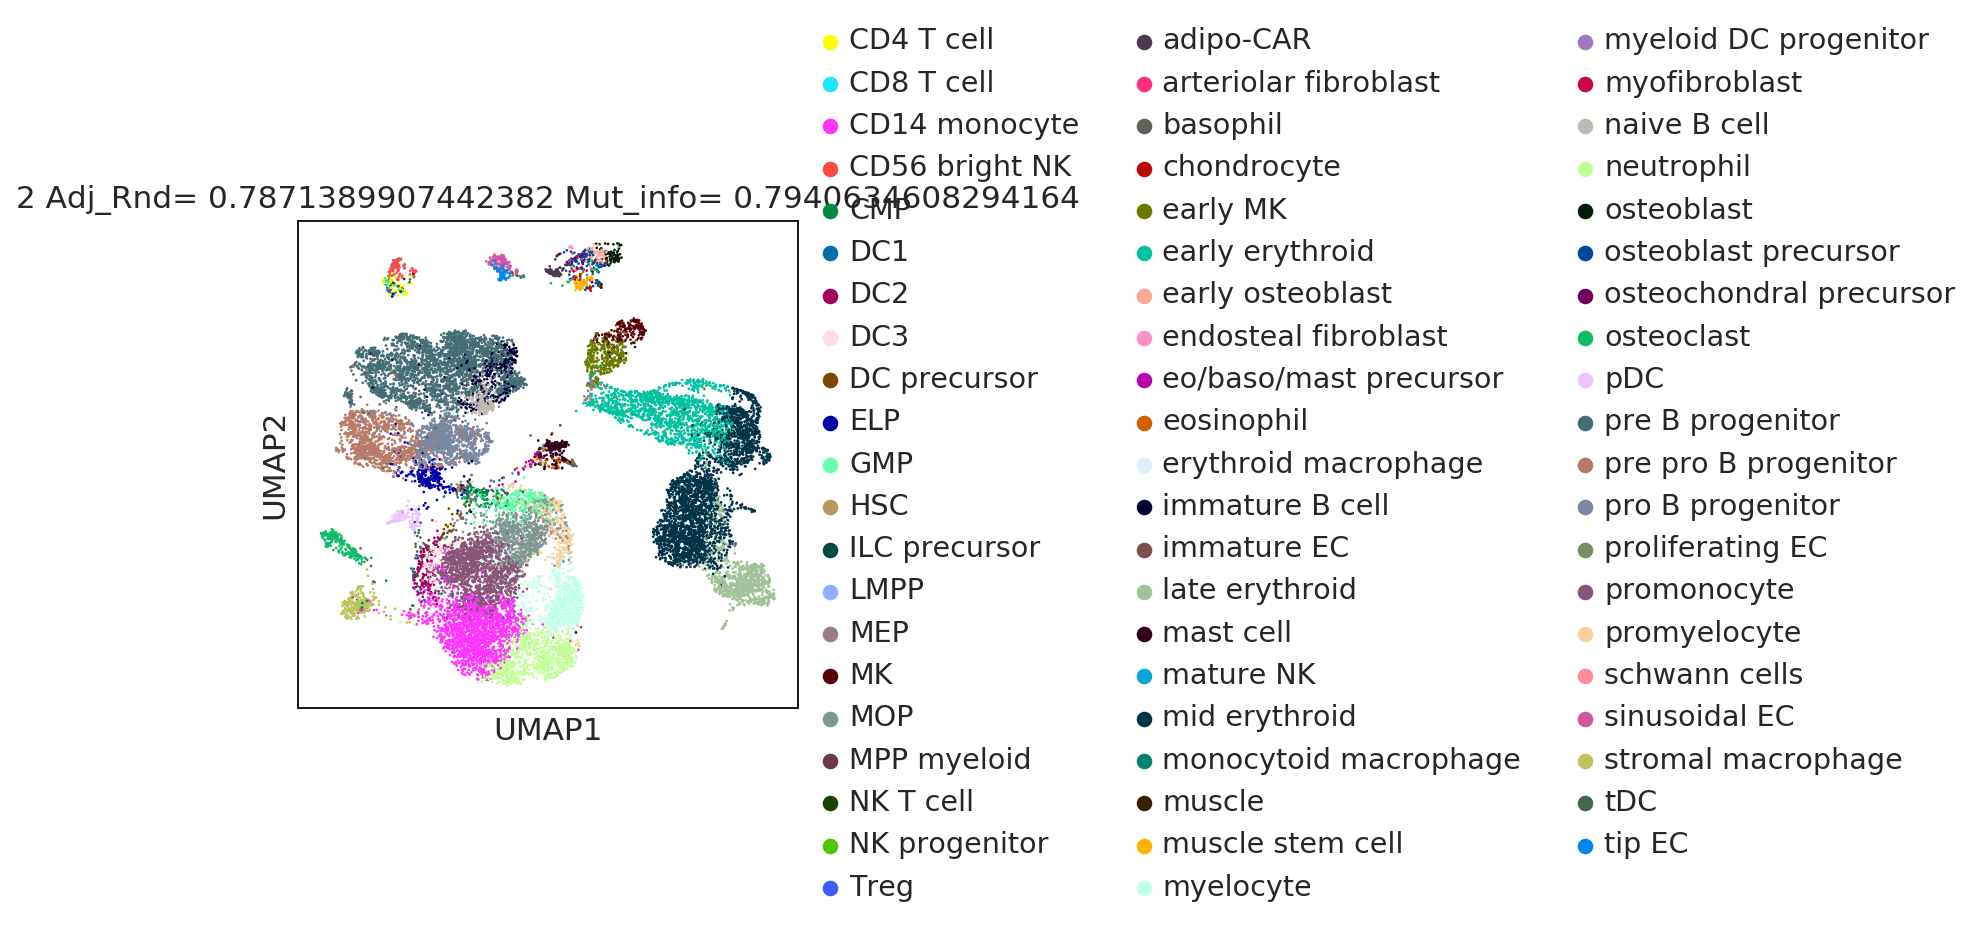

Umap, rand,Mi plotted for loop with harmony theta = 2!
end of loop!
Commencing harmony


2021-02-04 19:02:18,423 - harmonypy - INFO - Iteration 1 of 10
2021-02-04 19:02:47,520 - harmonypy - INFO - Iteration 2 of 10
2021-02-04 19:03:16,148 - harmonypy - INFO - Iteration 3 of 10
2021-02-04 19:03:49,925 - harmonypy - INFO - Iteration 4 of 10
2021-02-04 19:04:30,244 - harmonypy - INFO - Iteration 5 of 10
2021-02-04 19:05:06,693 - harmonypy - INFO - Converged after 5 iterations


computing neighbors
    using 'X_pca' with n_pcs = 50


/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../my-conda-envs/base_100920/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
computing UMAP


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:04)


/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

LR_predictions completed for loop with harmony thetha = 3!
LR probs saved for loop 3!


Trying to set attribute `.obs` of view, copying.
... storing 'corr_concat' as categorical
... storing 'predicted' as categorical
... storing 'clus_prediction' as categorical


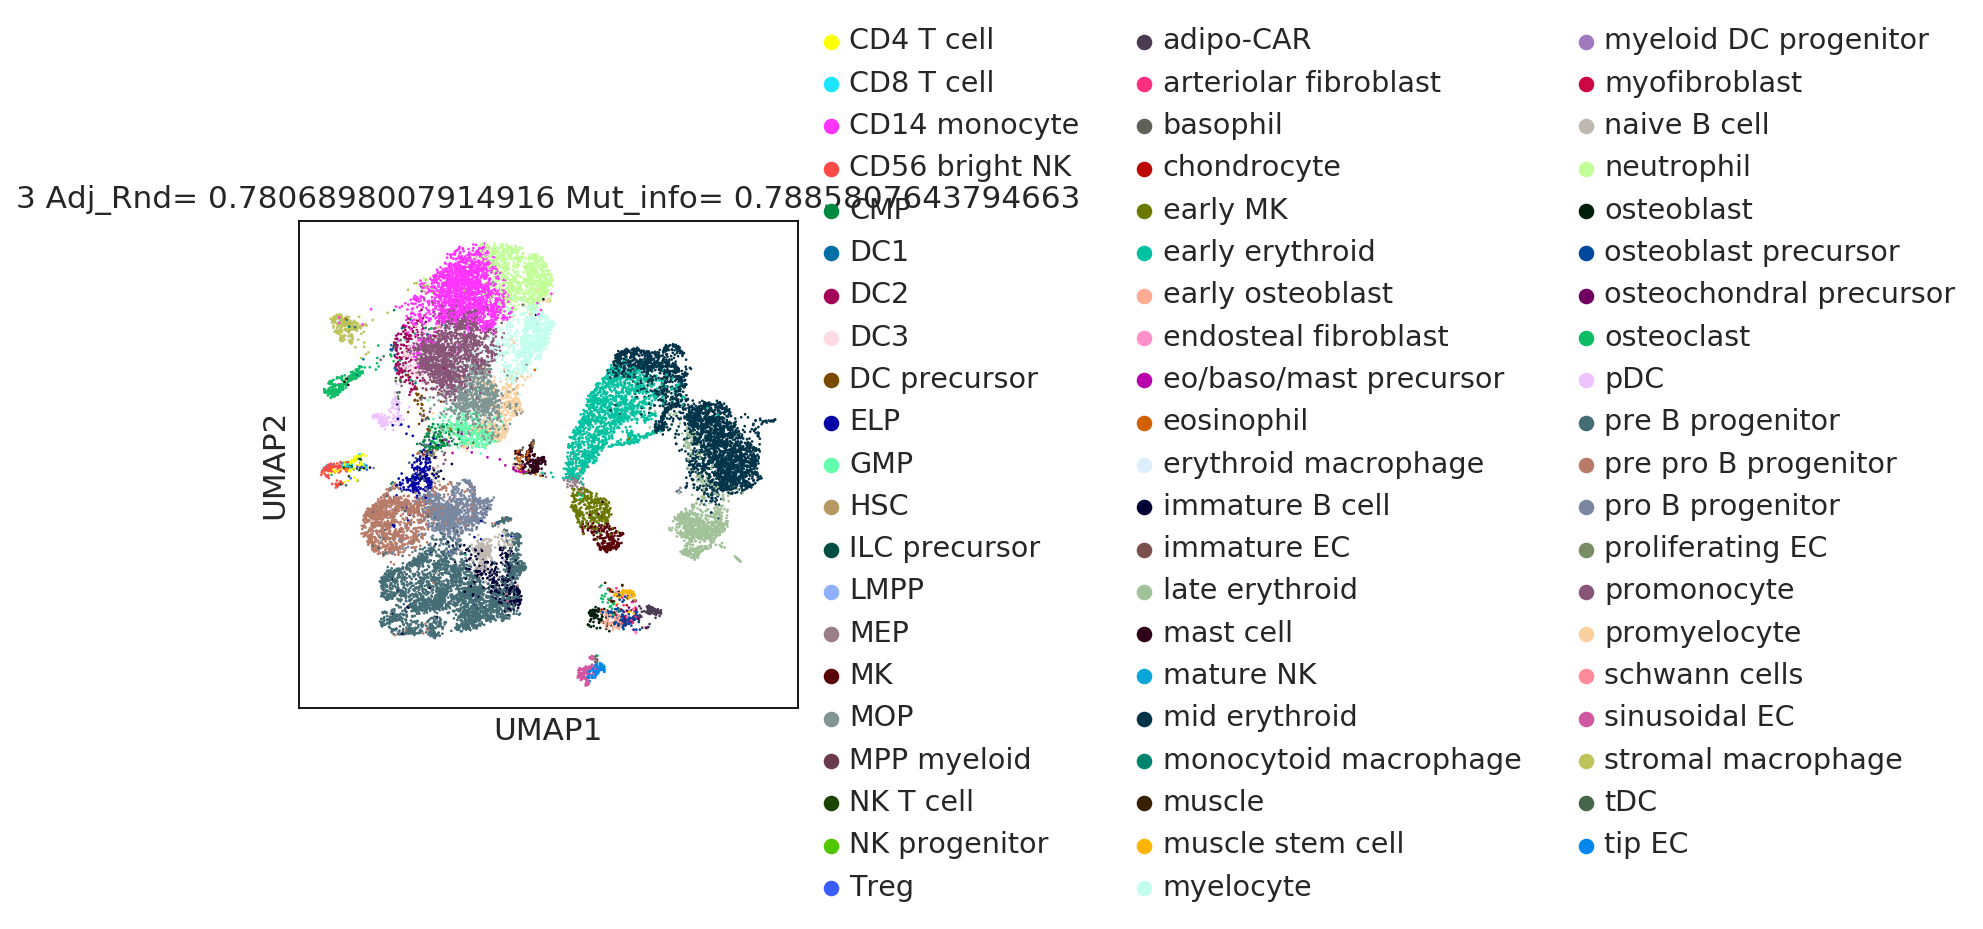

Umap, rand,Mi plotted for loop with harmony theta = 3!
end of loop!
Commencing harmony


2021-02-04 19:07:07,033 - harmonypy - INFO - Iteration 1 of 10
2021-02-04 19:07:44,697 - harmonypy - INFO - Iteration 2 of 10
2021-02-04 19:08:19,103 - harmonypy - INFO - Iteration 3 of 10
2021-02-04 19:08:49,438 - harmonypy - INFO - Iteration 4 of 10
2021-02-04 19:09:32,718 - harmonypy - INFO - Iteration 5 of 10
2021-02-04 19:10:04,642 - harmonypy - INFO - Converged after 5 iterations


computing neighbors
    using 'X_pca' with n_pcs = 50


/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../my-conda-envs/base_100920/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
computing UMAP


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:01)


/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

LR_predictions completed for loop with harmony thetha = 4!
LR probs saved for loop 4!


Trying to set attribute `.obs` of view, copying.
... storing 'corr_concat' as categorical
... storing 'predicted' as categorical
... storing 'clus_prediction' as categorical


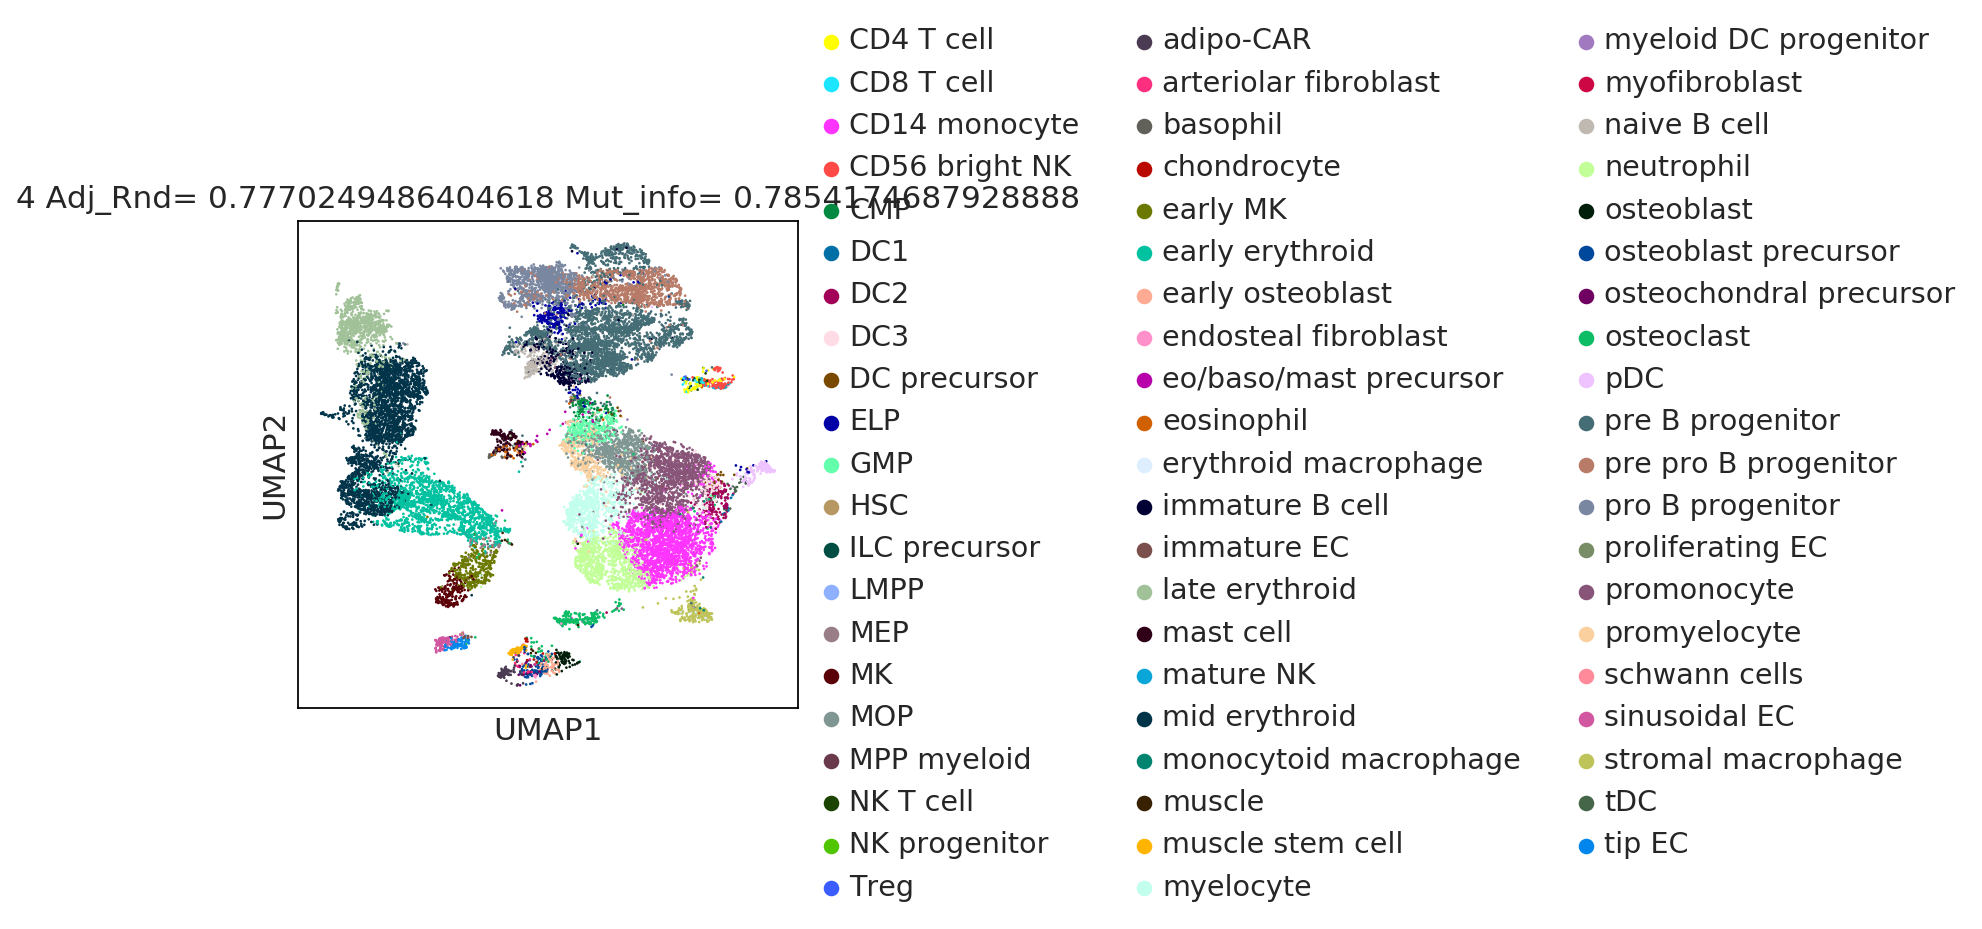

Umap, rand,Mi plotted for loop with harmony theta = 4!
end of loop!
Commencing harmony


2021-02-04 19:12:08,407 - harmonypy - INFO - Iteration 1 of 10
2021-02-04 19:12:46,551 - harmonypy - INFO - Iteration 2 of 10
2021-02-04 19:13:15,620 - harmonypy - INFO - Iteration 3 of 10
2021-02-04 19:13:45,062 - harmonypy - INFO - Iteration 4 of 10
2021-02-04 19:14:14,101 - harmonypy - INFO - Iteration 5 of 10
2021-02-04 19:14:44,114 - harmonypy - INFO - Converged after 5 iterations


computing neighbors
    using 'X_pca' with n_pcs = 50


/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../my-conda-envs/base_100920/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
computing UMAP


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:05)


/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

LR_predictions completed for loop with harmony thetha = 5!
LR probs saved for loop 5!


Trying to set attribute `.obs` of view, copying.
... storing 'corr_concat' as categorical
... storing 'predicted' as categorical
... storing 'clus_prediction' as categorical


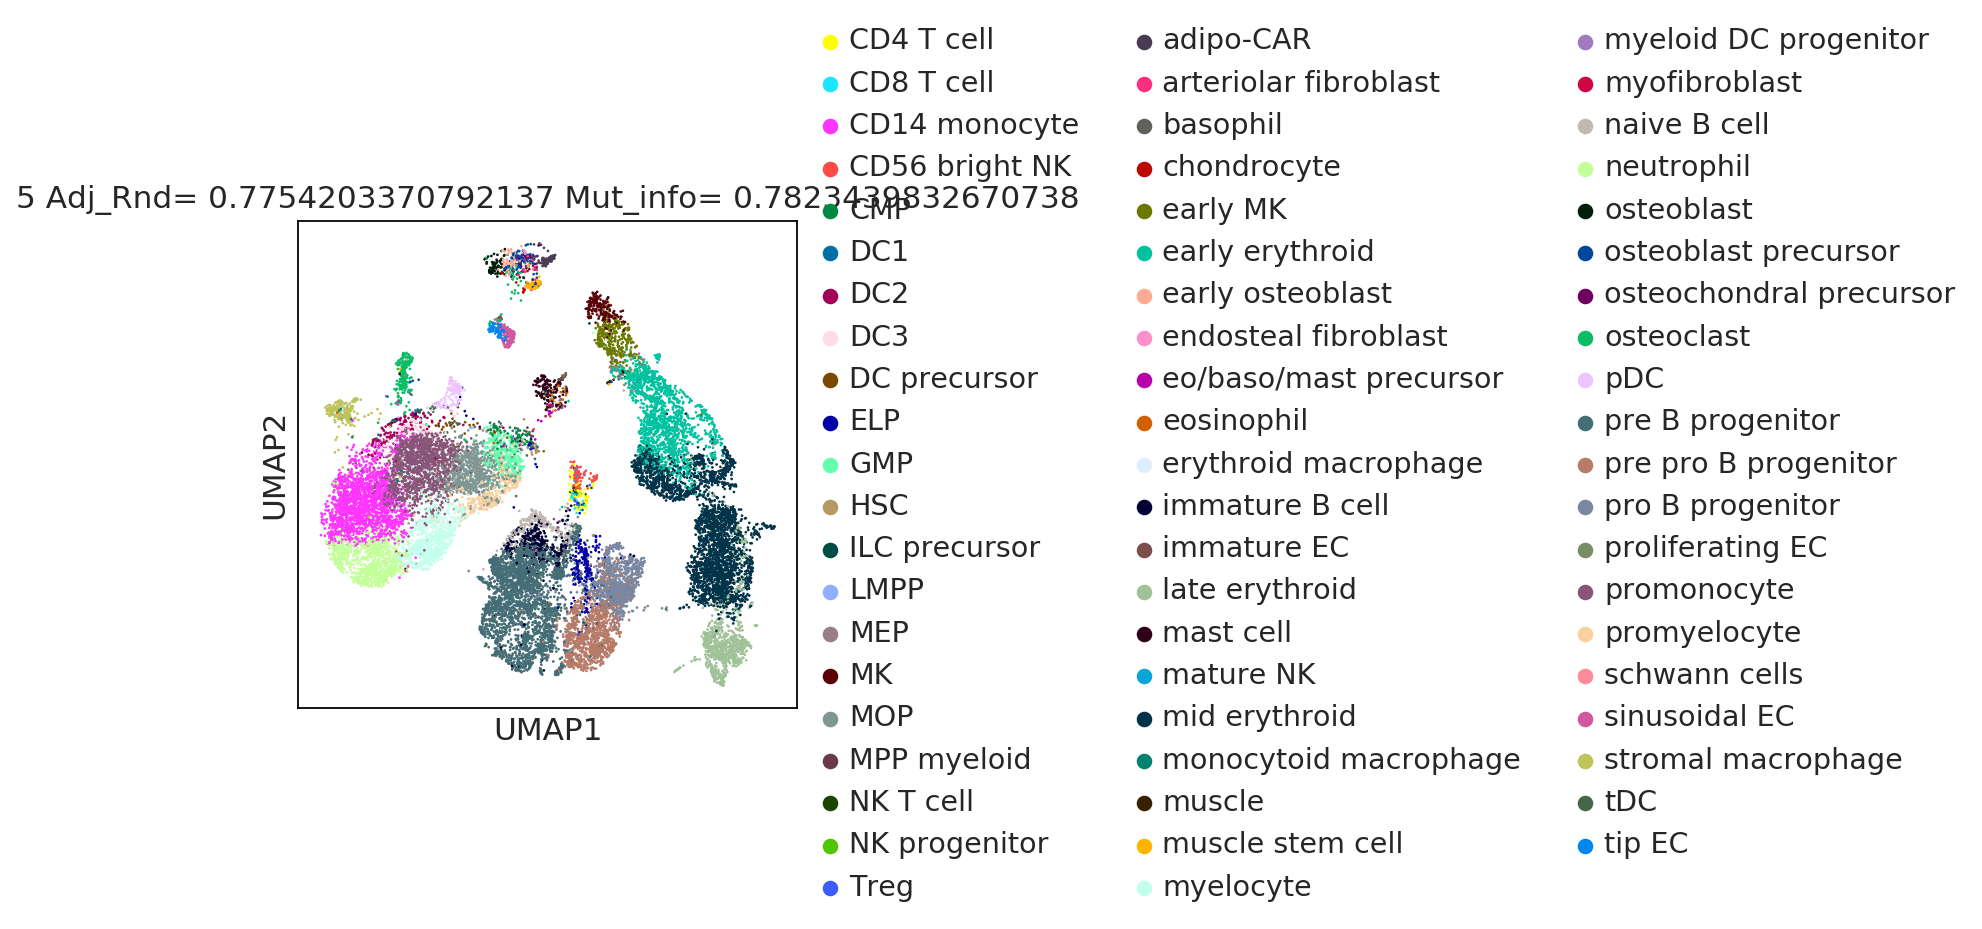

Umap, rand,Mi plotted for loop with harmony theta = 5!
end of loop!
Commencing harmony


2021-02-04 19:16:39,740 - harmonypy - INFO - Iteration 1 of 10
2021-02-04 19:17:15,927 - harmonypy - INFO - Iteration 2 of 10
2021-02-04 19:17:56,486 - harmonypy - INFO - Iteration 3 of 10
2021-02-04 19:18:27,845 - harmonypy - INFO - Iteration 4 of 10
2021-02-04 19:18:54,151 - harmonypy - INFO - Iteration 5 of 10
2021-02-04 19:19:41,588 - harmonypy - INFO - Converged after 5 iterations


computing neighbors
    using 'X_pca' with n_pcs = 50


/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../my-conda-envs/base_100920/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)
computing UMAP


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:59)


/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

LR_predictions completed for loop with harmony thetha = 6!
LR probs saved for loop 6!


Trying to set attribute `.obs` of view, copying.
... storing 'corr_concat' as categorical
... storing 'predicted' as categorical
... storing 'clus_prediction' as categorical


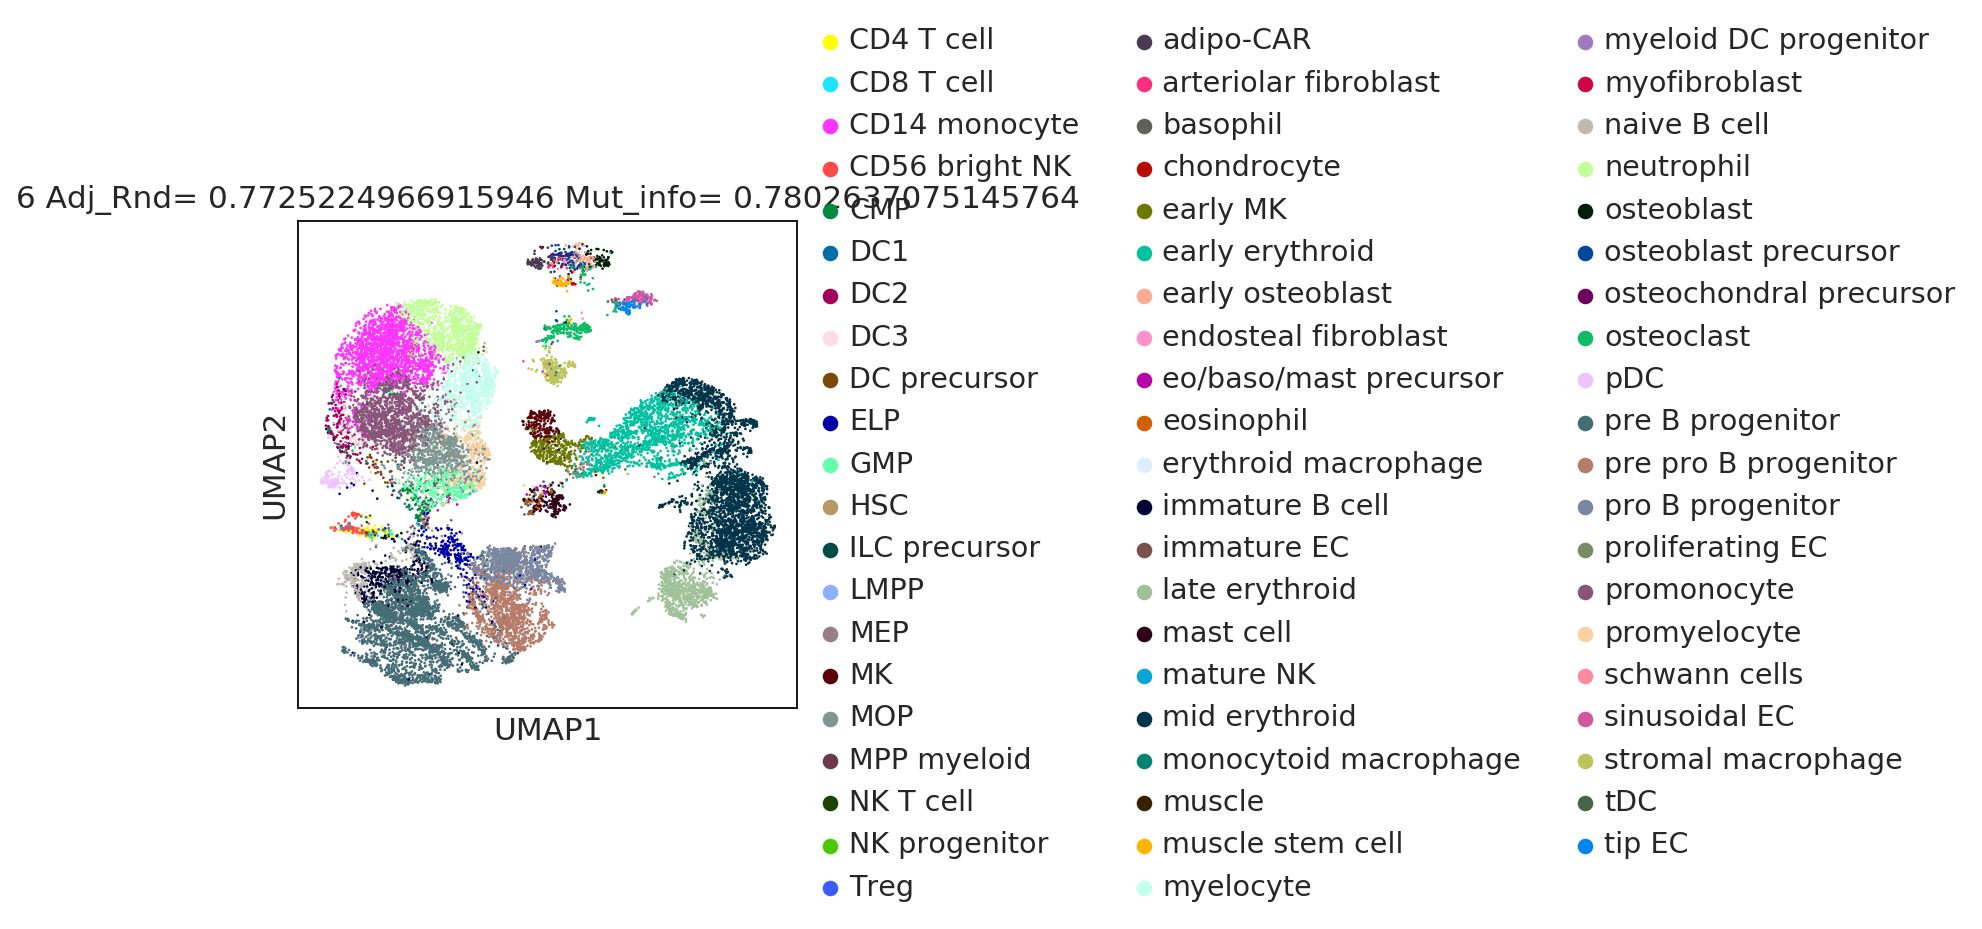

Umap, rand,Mi plotted for loop with harmony theta = 6!
end of loop!
Commencing harmony


2021-02-04 19:21:45,031 - harmonypy - INFO - Iteration 1 of 10
2021-02-04 19:22:21,433 - harmonypy - INFO - Iteration 2 of 10
2021-02-04 19:23:06,792 - harmonypy - INFO - Iteration 3 of 10
2021-02-04 19:23:36,516 - harmonypy - INFO - Iteration 4 of 10
2021-02-04 19:23:54,813 - harmonypy - INFO - Iteration 5 of 10
2021-02-04 19:24:34,736 - harmonypy - INFO - Converged after 5 iterations


computing neighbors
    using 'X_pca' with n_pcs = 50


/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../my-conda-envs/base_100920/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)
computing UMAP


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:01)


/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

LR_predictions completed for loop with harmony thetha = 7!
LR probs saved for loop 7!


Trying to set attribute `.obs` of view, copying.
... storing 'corr_concat' as categorical
... storing 'predicted' as categorical
... storing 'clus_prediction' as categorical


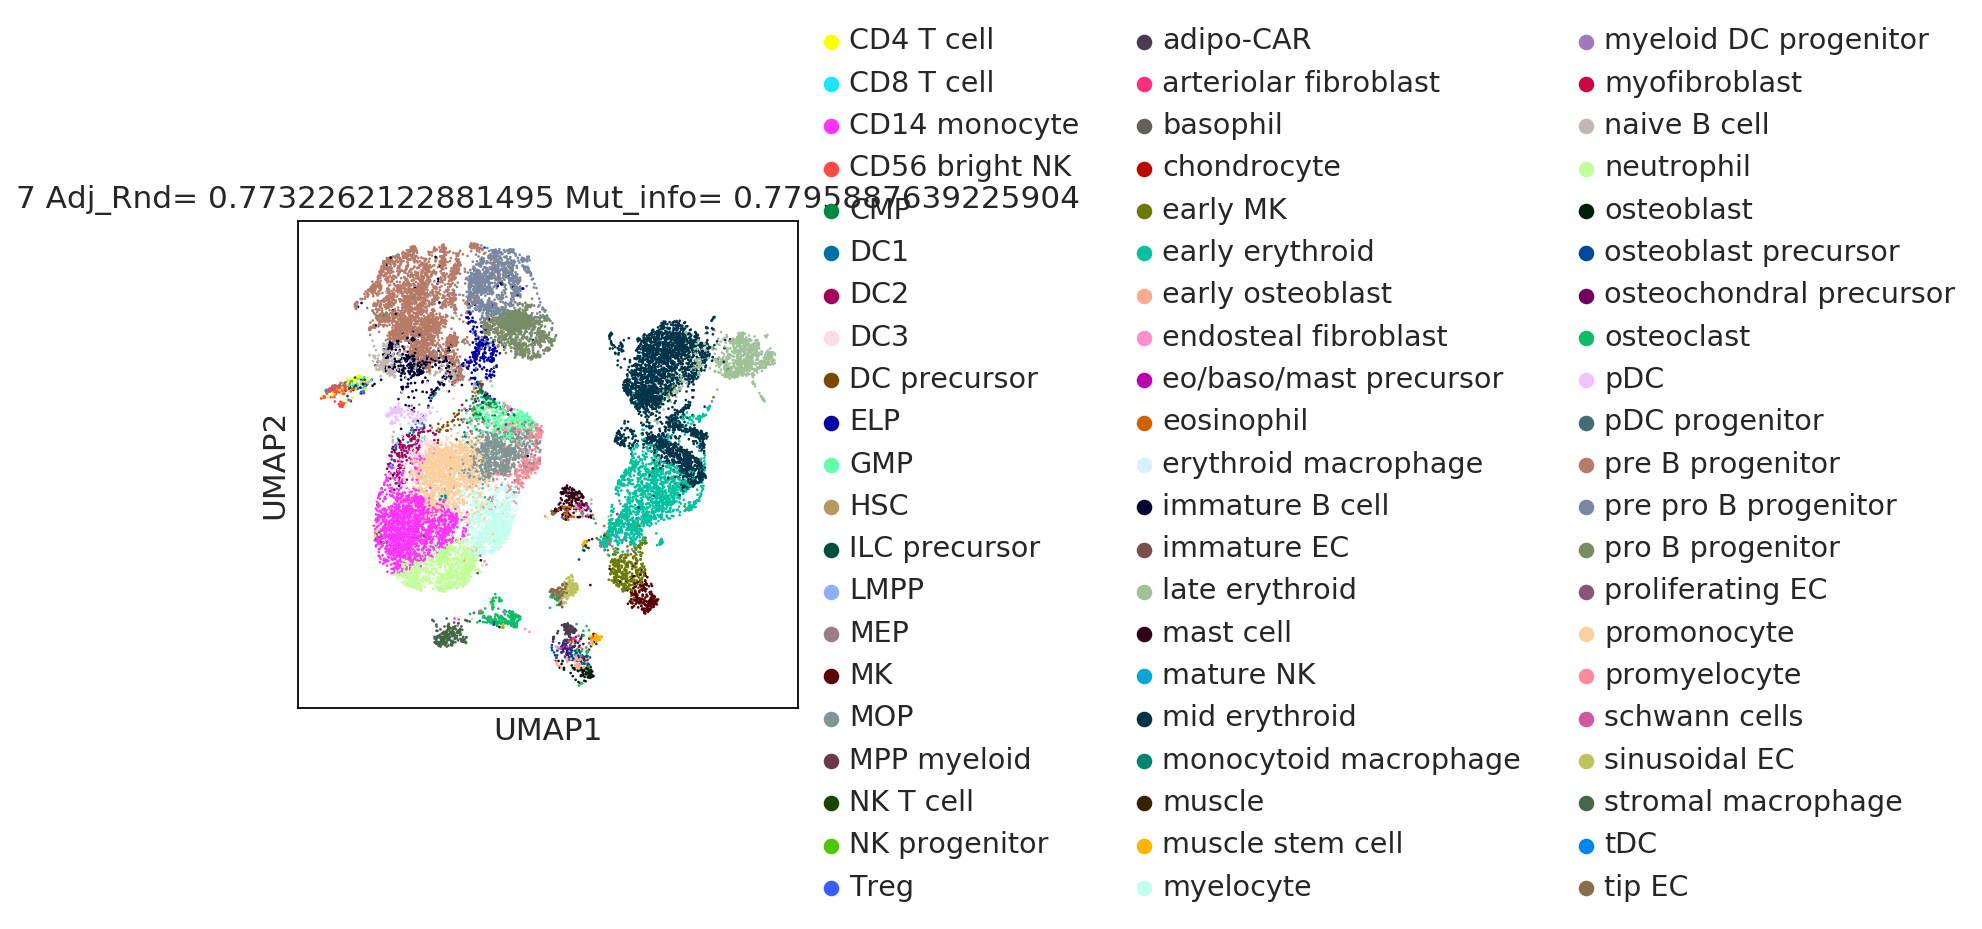

Umap, rand,Mi plotted for loop with harmony theta = 7!
end of loop!
Commencing harmony


2021-02-04 19:26:48,157 - harmonypy - INFO - Iteration 1 of 10
2021-02-04 19:27:27,841 - harmonypy - INFO - Iteration 2 of 10
2021-02-04 19:27:57,535 - harmonypy - INFO - Iteration 3 of 10
2021-02-04 19:28:32,811 - harmonypy - INFO - Iteration 4 of 10
2021-02-04 19:28:58,535 - harmonypy - INFO - Iteration 5 of 10
2021-02-04 19:29:36,392 - harmonypy - INFO - Converged after 5 iterations


computing neighbors
    using 'X_pca' with n_pcs = 50


/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../my-conda-envs/base_100920/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:00)


/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

LR_predictions completed for loop with harmony thetha = 8!
LR probs saved for loop 8!


Trying to set attribute `.obs` of view, copying.
... storing 'corr_concat' as categorical
... storing 'predicted' as categorical
... storing 'clus_prediction' as categorical


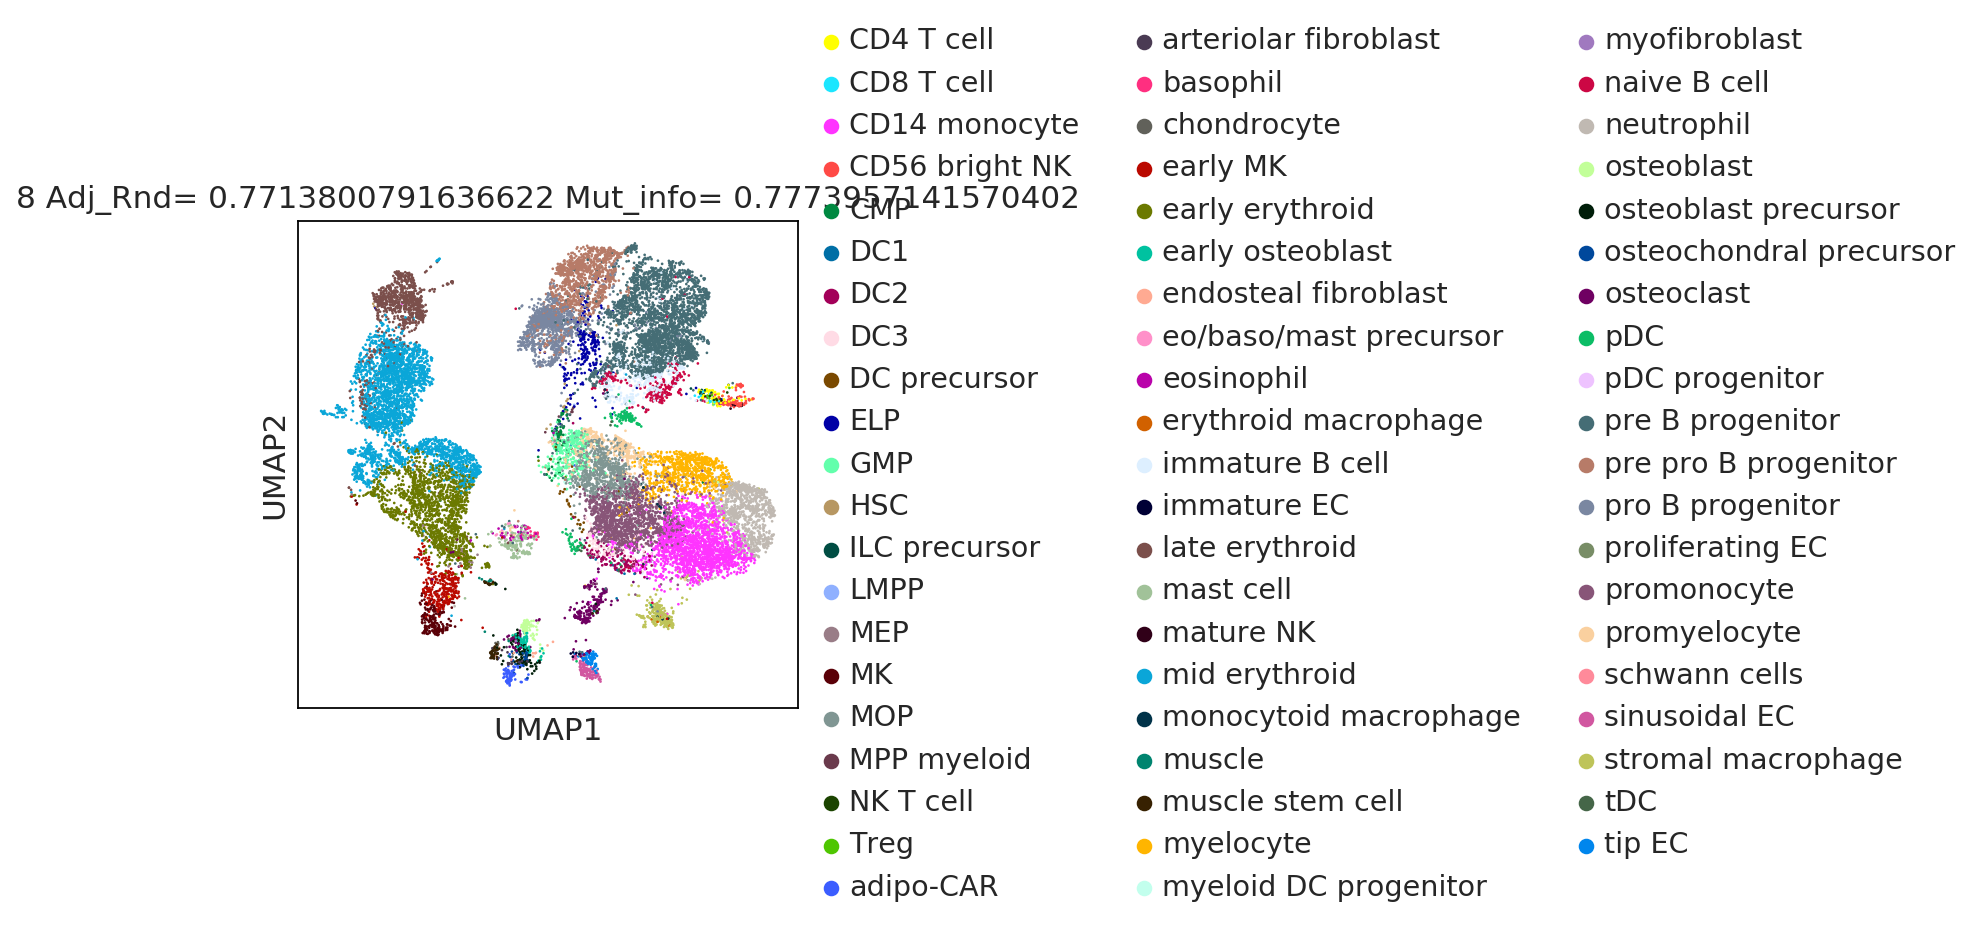

Umap, rand,Mi plotted for loop with harmony theta = 8!
end of loop!
Commencing harmony


2021-02-04 19:31:43,460 - harmonypy - INFO - Iteration 1 of 10
2021-02-04 19:32:26,432 - harmonypy - INFO - Iteration 2 of 10
2021-02-04 19:32:58,191 - harmonypy - INFO - Iteration 3 of 10
2021-02-04 19:33:15,232 - harmonypy - INFO - Iteration 4 of 10
2021-02-04 19:33:40,094 - harmonypy - INFO - Iteration 5 of 10
2021-02-04 19:34:26,597 - harmonypy - INFO - Converged after 5 iterations


computing neighbors
    using 'X_pca' with n_pcs = 50


/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../my-conda-envs/base_100920/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
computing UMAP


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:47)


/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

LR_predictions completed for loop with harmony thetha = 9!
LR probs saved for loop 9!


... storing 'corr_concat' as categorical
... storing 'predicted' as categorical
... storing 'clus_prediction' as categorical


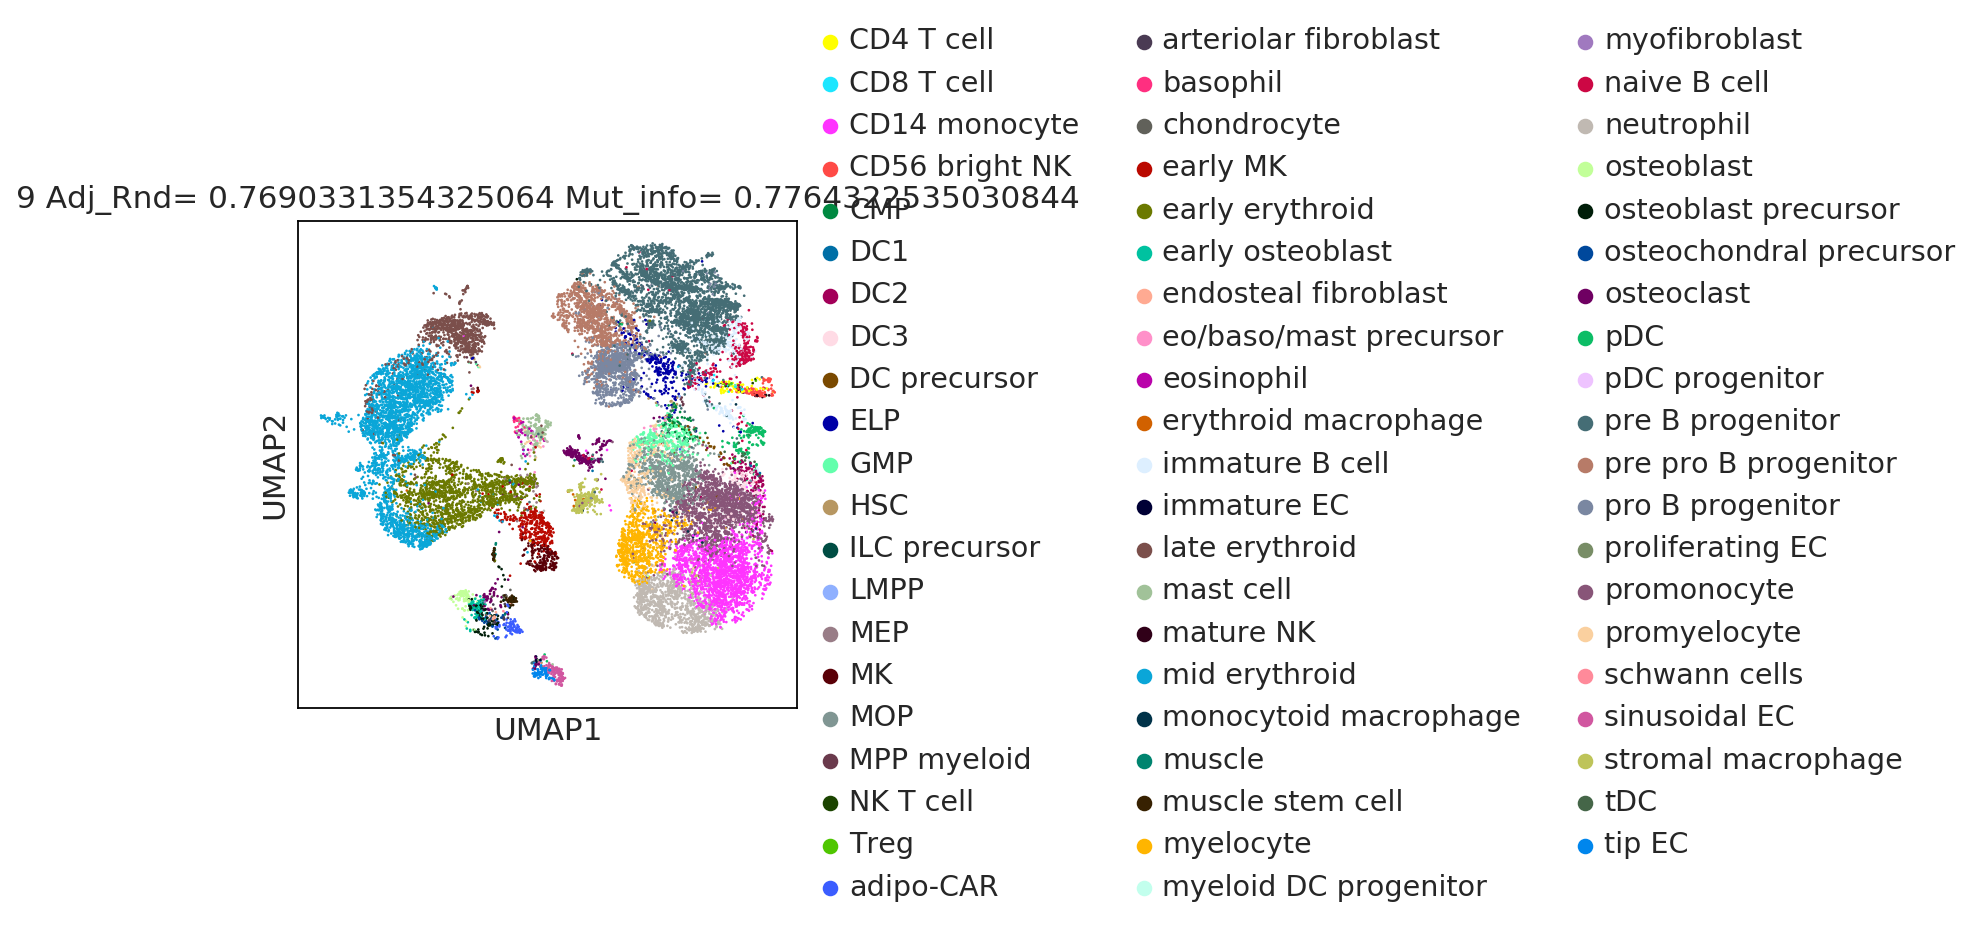

Umap, rand,Mi plotted for loop with harmony theta = 9!
end of loop!
Commencing harmony


2021-02-04 19:36:13,439 - harmonypy - INFO - Iteration 1 of 10
2021-02-04 19:36:43,447 - harmonypy - INFO - Iteration 2 of 10
2021-02-04 19:37:10,318 - harmonypy - INFO - Iteration 3 of 10
2021-02-04 19:37:39,350 - harmonypy - INFO - Iteration 4 of 10
2021-02-04 19:37:59,148 - harmonypy - INFO - Iteration 5 of 10
2021-02-04 19:38:29,041 - harmonypy - INFO - Iteration 6 of 10
2021-02-04 19:38:48,390 - harmonypy - INFO - Iteration 7 of 10
2021-02-04 19:39:08,342 - harmonypy - INFO - Converged after 7 iterations


computing neighbors
    using 'X_pca' with n_pcs = 50


/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../my-conda-envs/base_100920/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP


Trying to set attribute `.uns` of view, copying.


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:45)


/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/jovyan/my-conda-envs/base_100920/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

LR_predictions completed for loop with harmony thetha = 10!
LR probs saved for loop 10!


... storing 'corr_concat' as categorical
... storing 'predicted' as categorical
... storing 'clus_prediction' as categorical


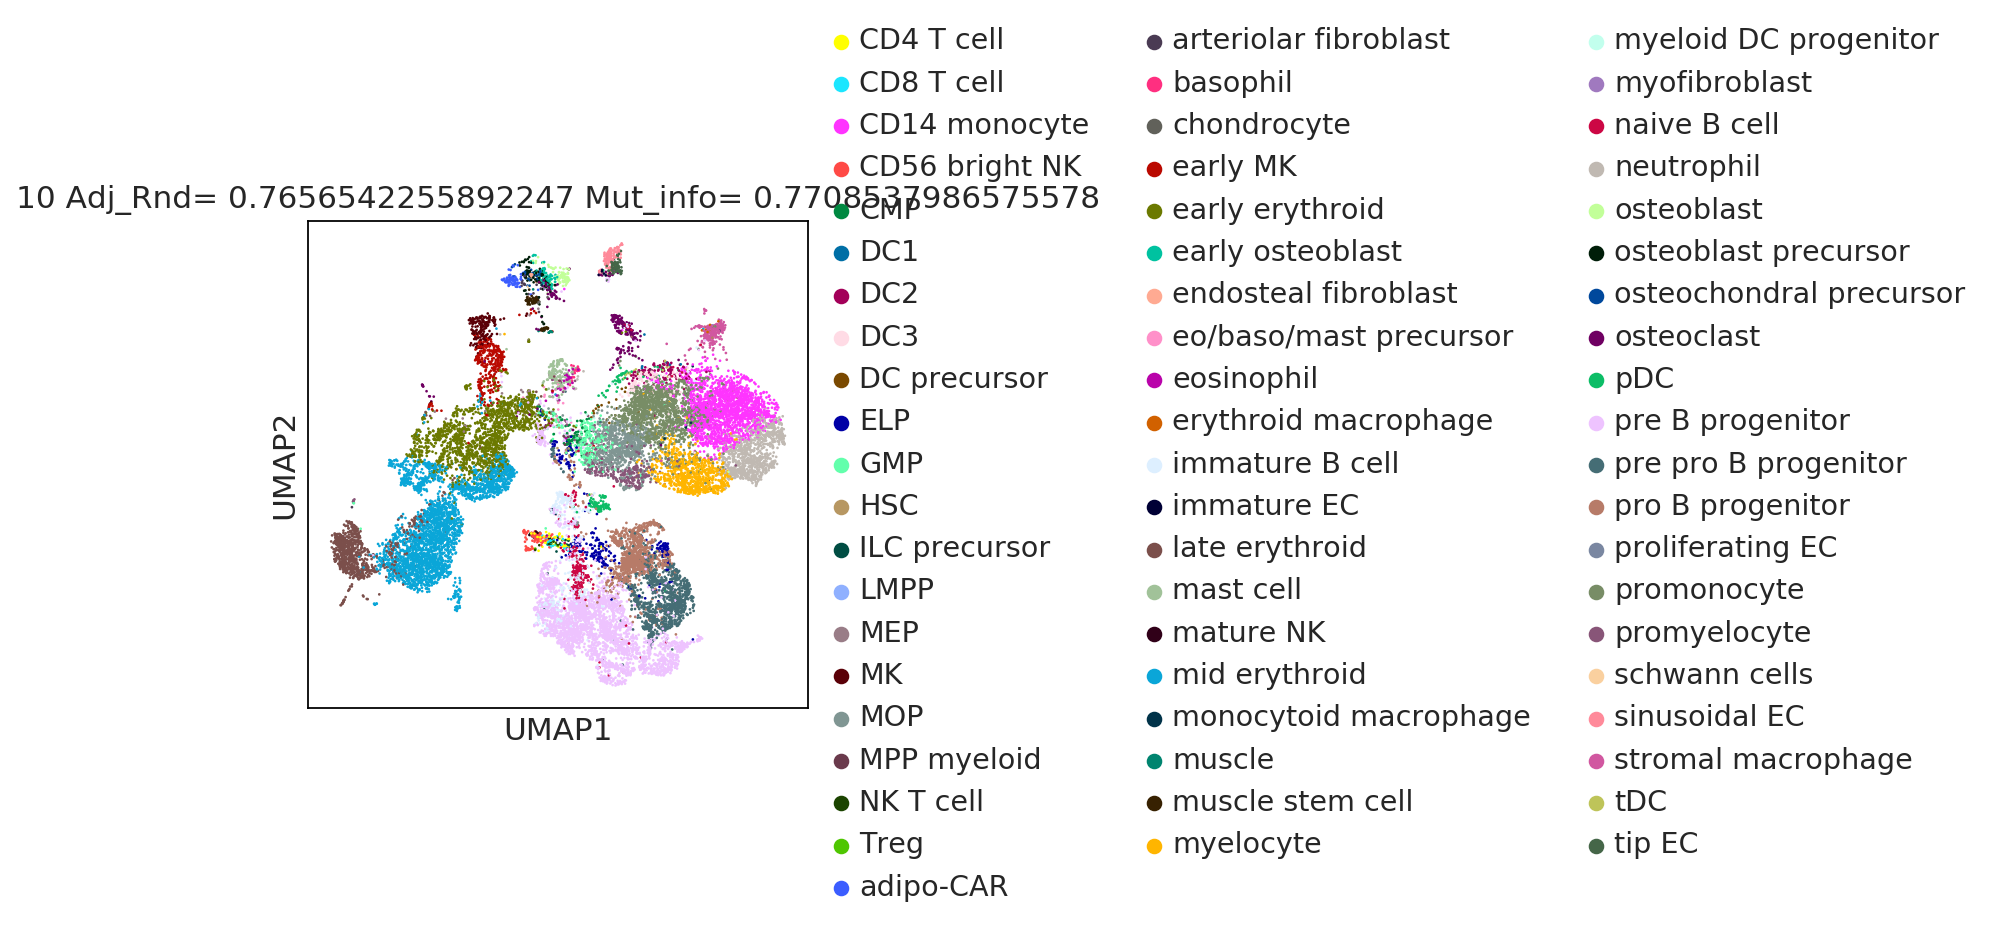

Umap, rand,Mi plotted for loop with harmony theta = 10!
end of loop!


In [6]:

#Create output directory
if os.path.exists(output) == True:
    print("Path already exists!")
else:
    os.mkdir(output)

os.chdir('./'+output)
print(os.getcwd())

#Start of the subset and plotting loop

adata = adata_orig[:]
adata2 = adata[:]
    #adata2 = adata2[~adata2.obs[donor_id].isin([i])]
#name of second object
data2 = "_prediction"
#provide cateorical to join between datasets
cat2 = cat1
    
#create a common obs column in both datasets containing the data origin tag
common_cat = "corr_concat" 
adata.obs[common_cat] = adata.obs[cat1].astype(str) + data1
adata2.obs[common_cat] = adata2.obs[cat2].astype(str) + data2
adata.obs = adata.obs.astype('category')
adata2.obs = adata2.obs.astype('category')
    #adata.raw = adata
    #adata2.raw = adata2

#concat the data
concat = adata.concatenate(adata2, join='inner', index_unique='-', batch_key='Status')
adata = concat
print('data_concatenated!')
#Get PCA by covarainces of variable genes
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=4)

#Get control PCA, snn and umap coord without harmony:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata,n_neighbors=15, n_pcs=50)
#sc.tl.umap(adata)

#Create a subsample to save on re sampling
grouped = adata.obs.groupby('corr_concat')
df = grouped.apply(lambda x: x.sample(frac=0.2))
df = df.droplevel('corr_concat')
keep = df.index
adata = adata[adata.obs.index.isin(keep)]

#make a copy
adata_loop_start = adata[:]

######################################

for i in inte:
#Batch correction
    adata = adata_loop_start[:]
    if (correction == "Harmony"): 
        print("Commencing harmony")
        #Create hm subset
        adata_hm = adata[:]
        #sc.pp.pca(adata_hm, n_comps=50, use_highly_variable=True, svd_solver='arpack')
        #Set harmony variables
        data_mat = np.array(adata_hm.obsm["X_pca"])
        meta_data = adata_hm.obs
        vars_use = [batch]
        #Run Harmony
        ho = hm.run_harmony(data_mat, meta_data, vars_use, theta = i)
        res = (pd.DataFrame(ho.Z_corr)).T
        res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
        #Insert coordinates back into object
        adata_hm.obsm["X_pca_back"]= adata_hm.obsm["X_pca"][:]
        adata_hm.obsm["X_pca"] = np.array(res)
        #Run neighbours
        sc.pp.neighbors(adata_hm,n_neighbors=15, n_pcs=50)
        adata = adata_hm[:]
        sc.tl.umap(adata)

    else:
        print("Commencing BBKNN")
        sc.pp.pca(adata, n_comps=i, use_highly_variable=False, svd_solver='arpack')
        sc.external.pp.bbknn(adata, batch_key=batch, approx=True, metric='angular', copy=False, n_pcs=i, trim=None, n_trees=10, use_faiss=True, set_op_mix_ratio=1.0, local_connectivity=1)
        sc.tl.umap(adata)

#Define the seprator category in the column of interest, this works by partial matches and enables a-symmetric comparisons
    Data1_group = data1
    Data2_group = data2

#Define the common .obs column between cancatinated data
    common_cat = "corr_concat"

#Define the resource to train and predict on, PCA or X or UMAP (#if you wish to use gene expression, train_x = 'X' or 'X_pca' , or 'X_umap'
    #train_x = 'X'
    train_x = 'X_pca'
    ########################################################################################
    group1 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data1_group)]).unique()
    group1 = list(group1)
    group2 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data2_group)]).unique()
    group2 = list(group2)
    subset_predict = np.array(adata.obs[common_cat].isin(group2))
    subset_train = np.array(adata.obs[common_cat].isin(group1))
    train_label = adata.obs[common_cat].values
    #########################################################################################
    
#Run LR
    LR_compare(adata, train_x,train_label,subset_predict, subset_train,penalty='l1',sparcity=0.2,col_name='predicted')
    print('LR_predictions completed for loop with harmony thetha = ' + str(i) + '!' )
#Plot predictions in probability heatmap
    x='predicted'
    y = common_cat
    y_attr = adata.obs[y]
    x_attr = adata.obs[x]
    crs_tbl = pd.crosstab(x_attr, y_attr)
    #crs_tbl_test = crs_tbl
    
#Cross table removes all result which have 0 matches, add these back into table
    vals = list(crs_tbl.index)
    pred = pd.DataFrame(group1)
    missing_vals = pred.iloc[:,0][~(pred.iloc[:,0].isin(vals))]
    crs_tbl = crs_tbl.T
    for missing in missing_vals:
        crs_tbl[missing] = 0
    crs_tbl = crs_tbl.reindex(sorted(crs_tbl.columns), axis=1)
    crs_tbl = crs_tbl.T
    crs_tbl = crs_tbl.reindex(sorted(crs_tbl.columns), axis=1)
    for col in crs_tbl :
        crs_tbl[col] = crs_tbl[col].div(crs_tbl[col].sum(axis=0)).multiply(100)

#Optionally save this image!
    #plot_df_heatmap(crs_tbl.T, cmap='coolwarm', rotation=90, figsize=figsize, vmin=20, vmax=70)
    #pal = sns.diverging_palette(240, 10, n=10)
    #g = sns.clustermap(crs_tbl.T, cmap=pal,vmin=20, vmax=70,linewidths=.5)
    #g = sns.heatmap(crs_tbl, cmap=pal, vmin=0, vmax=100,linewidths=.5 ,center=50,square=True )
    #plt.show();
    
#Save probability distribution
    prob_out_name = "./logist_prediction_harmony_theta_" + str(i)+ ".csv"
    crs_tbl.to_csv(prob_out_name)
    print("LR probs saved for loop " + str(i) +"!")
############################

    #Crete a holder for current prediction obj
    adata_predicted = adata[:]
    adata_predicted = adata_predicted[(adata_predicted.obs[common_cat].isin(group2))]
    adata_predicted.obs[common_cat].astype(str)
    adata_predicted.obs['predicted'] = adata_predicted.obs["predicted"].astype(str)
    
#Frequency redistribution by additive assignment if reclustering is done
    cluster_prediction = "clus_prediction"
    #clusters_reassign = "leiden_res5"
    #res= 5
    #lr_predicted_col = 'predicted'
    
##Plot Umap with Rand index and mutual info score
    #sc.pp.neighbors(adata_predicted,n_neighbors=15, n_pcs=i)
    #sc.pp.highly_variable_genes(adata_predicted, min_mean=0.1, max_mean=4)

    #sc.tl.leiden(adata_predicted, resolution= res, key_added= clusters_reassign, random_state=24, n_iterations=-1)
    #adata_predicted.obs[cluster_prediction] = adata_predicted.obs.index
    #for z in adata_predicted.obs[clusters_reassign].unique():
    #    df = adata_predicted.obs
    #    df = df[(df[clusters_reassign].isin([z]))]
    #    df_count = pd.DataFrame(df[lr_predicted_col].value_counts())
    #    freq_arranged = df_count.index
    #    cat = freq_arranged[0]
    #    df.loc[:,cluster_prediction] = cat
    #    adata_predicted.obs.loc[adata_predicted.obs[clusters_reassign] == z, [cluster_prediction]] = cat
    adata_predicted.obs[cluster_prediction] = adata_predicted.obs['predicted']
#caculate Rand and MI
    rand=sklearn.metrics.adjusted_rand_score(list(adata_predicted.obs[cat1]), list(adata_predicted.obs[cluster_prediction]))
    mi=sklearn.metrics.adjusted_mutual_info_score(list(adata_predicted.obs[cat1]), list(adata_predicted.obs[cluster_prediction]), average_method='arithmetic')
#include info in plot title
##Edit the predicted col and get all missing values
    adata_predicted.obs[cluster_prediction] = adata_predicted.obs[cluster_prediction].str.replace('_Training', '', regex=True)
    adata_predicted.obs[cluster_prediction]
    fig_name = str(i) + " Adj_Rnd= " + str(rand) + " Mut_info= " + str(mi)
    sc.pl.umap(adata_predicted,color=cluster_prediction,title = fig_name,save=("_"+str(i)+".png"))
    print("Umap, rand,Mi plotted for loop with harmony theta = " + str(i) + "!")
# prints the missing and additional elements in list2 into our dataframe
    missing = set(list(adata_predicted.obs[cat1])).difference(list(adata_predicted.obs[cluster_prediction]))

##Create data frame and populate with scoring metrics
    temp_score = pd.DataFrame(columns=[str(i)],dtype=object)
    temp_score = pd.DataFrame(temp_score.T)
    temp_score["adj_rand"] = rand
    temp_score["mutual_info"] = mi
    temp_score["missing_vals"] = "NAN"
    temp_score.at[str(i), "missing_vals"] = missing

    if 'concat_score' in globals():
        concat_score = pd.concat([concat_score, temp_score])
    else:
        concat_score = temp_score[:]

#Return resources back to system and restart the loop
    #gc.collect()
    print("end of loop!")
#Write out overall scored output
concat_score.to_csv("./concatenated_scores_harmony_theta_variation.csv")

In [12]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')

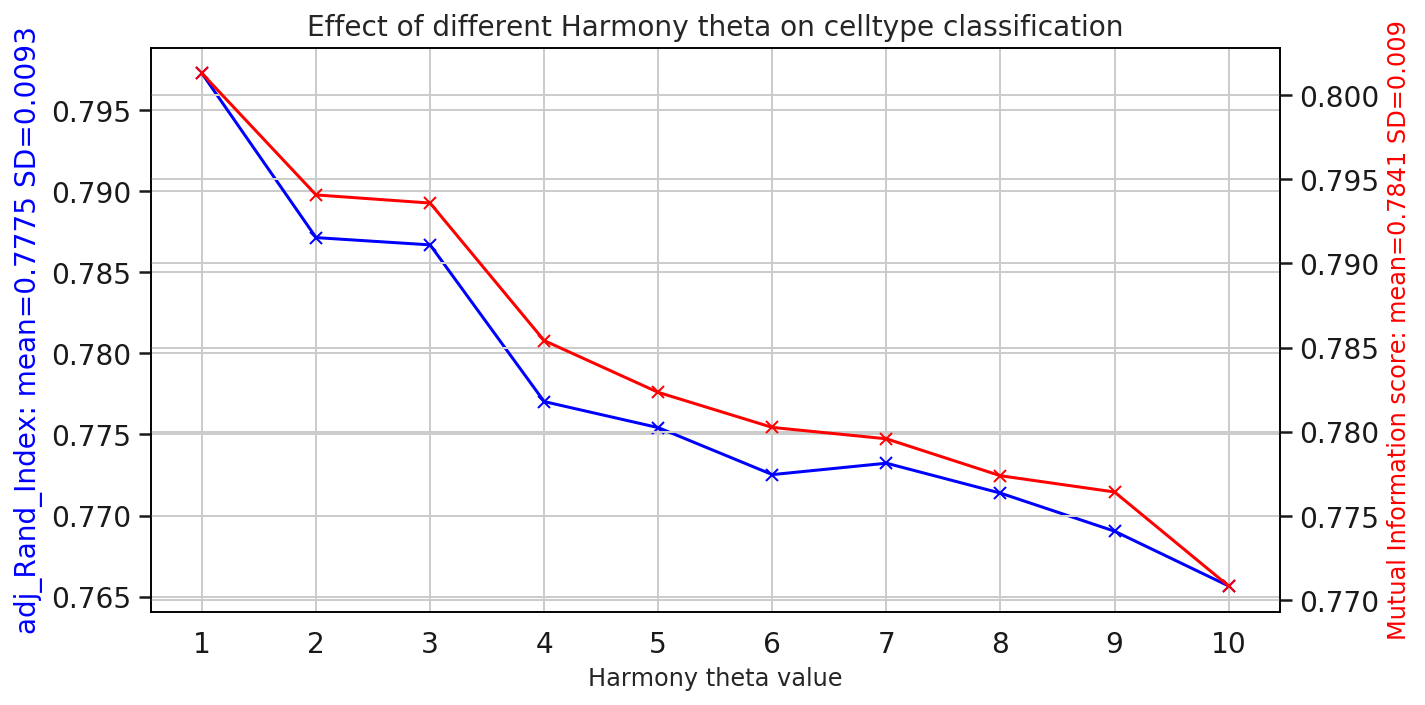

In [46]:
%matplotlib inline
import numpy as np
import scanpy as sc
import scipy as sci
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import gc

import os

import re

tables = os.listdir()
tables = [x for x in tables if x.endswith('.csv') and not x.startswith("concatenated")]
name = "./concatenated_scores_harmony_theta_variation.csv"
file = pd.read_csv(name)
#file = file.drop([0])
mean_rand = round(np.mean(file["adj_rand"]),4)
sd_rand = round(np.std(file["adj_rand"]),4)

mean_mi = round(np.mean(file["mutual_info"]),4)
sd_mi = round(np.std(file["mutual_info"]),4)
rand_x = file.iloc[:,0]
rand_y = file["adj_rand"]
mi_x = file.iloc[:,0]
mi_y= file["mutual_info"]


from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize = (10,5))
# make a plot
ax.plot(rand_x, rand_y, 'bx-', color="blue")
# set x-axis label
ax.set_xlabel("Harmony theta value",fontsize=12)
# set y-axis label
rand_label = "adj_Rand_Index: mean="+str(mean_rand) + " SD=" + str(sd_rand)
ax.set_ylabel(rand_label,color="blue",fontsize=14)
# make a plot with different y-axis using second axis object
ax2=ax.twinx()
ax2.plot(mi_x, mi_y, 'bx-',color="red")
mi_label = "Mutual Information score: mean="+str(mean_mi) + " SD=" + str(sd_mi)
ax2.set_ylabel(mi_label,color="red",fontsize=12)
plt.title('Effect of different Harmony theta on celltype classification')
plt.savefig("./Harmony_theta_effect.pdf",dpi=200)
#Set X ticks to integer values
plt.xticks(np.arange(min(rand_x), (max(rand_x)+1), 1.0))
plt.show();

In [41]:
rand_x = file.iloc[:,0]

In [43]:
file

Unnamed: 0  adj_rand  mutual_info  \
0           1  0.797264     0.801275   
1           2  0.787139     0.794063   
2           3  0.786690     0.793581   
3           4  0.777025     0.785417   
4           5  0.775420     0.782344   
5           6  0.772522     0.780264   
6           7  0.773226     0.779589   
7           8  0.771380     0.777396   
8           9  0.769033     0.776432   
9          10  0.765654     0.770854   

                                  missing_vals  
0                   {'MEMP', 'pDC progenitor'}  
1                   {'MEMP', 'pDC progenitor'}  
2                   {'MEMP', 'pDC progenitor'}  
3                   {'MEMP', 'pDC progenitor'}  
4                   {'MEMP', 'pDC progenitor'}  
5                   {'MEMP', 'pDC progenitor'}  
6                                     {'MEMP'}  
7                    {'NK progenitor', 'MEMP'}  
8                    {'NK progenitor', 'MEMP'}  
9  {'NK progenitor', 'MEMP', 'pDC progenitor'}

In [42]:
rand_x

0     1
1     2
2     3
3     4
4     5
5     6
6     7
7     8
8     9
9    10
Name: Unnamed: 0, dtype: int64